In [11]:
import math
import random
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import pandas as pd

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

data_dir = 'pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

982    exc
Name: emotion, dtype: object


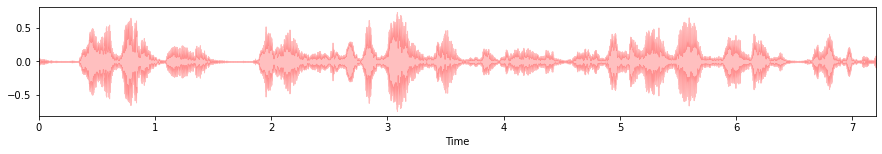

In [12]:
# Pick a Random File
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

filter = labels_df['wav_file']== random_file_name
  
# filtering data
print(labels_df[filter].emotion)

import IPython.display as ipd
yt, index = librosa.effects.trim(y)
ipd.Audio(yt, rate=sr)

In [13]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

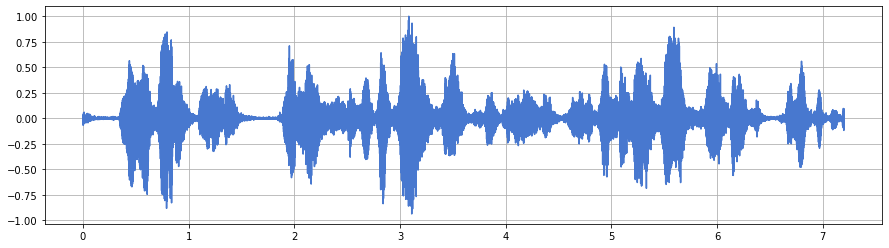

In [14]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

audio = normalize_audio(y)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.grid(True)

In [49]:
def frame_audio(audio, FFT_size=512, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    #frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    #Improve this to not missout on frames
    frame_num = 300
    frames = np.zeros((frame_num,FFT_size))
    #frames_remaining = np.zeros((300,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
        
#     for n in range(300,frame_num):
#         frames_remaining[n-300] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [16]:
hop_size = 10 #ms
FFT_size = 512

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)
print("Framed audio shape: {0}".format(audio_framed.shape))
#print("Framed Remaining audio shape: {0}".format(audio_remaining.shape))

Framed audio shape: (300, 512)


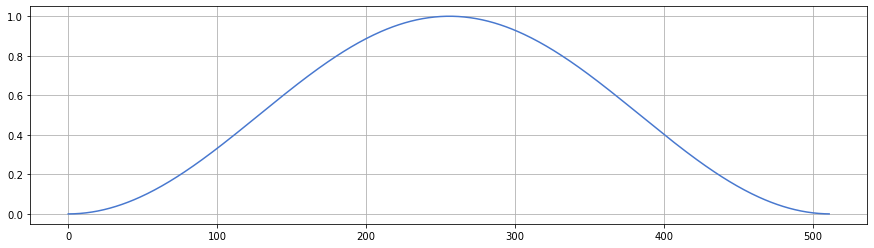

In [17]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline


window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

In [18]:
# audio_win = audio_remaining * window

# ind = 69
# plt.figure(figsize=(15,6))
# plt.subplot(2, 1, 1)
# plt.plot(audio_remaining[ind])
# plt.title('Original Frame')
# plt.grid(True)
# plt.subplot(2, 1, 2)
# plt.plot(audio_win[ind])
# plt.title('Frame After Windowing')
# plt.grid(True)

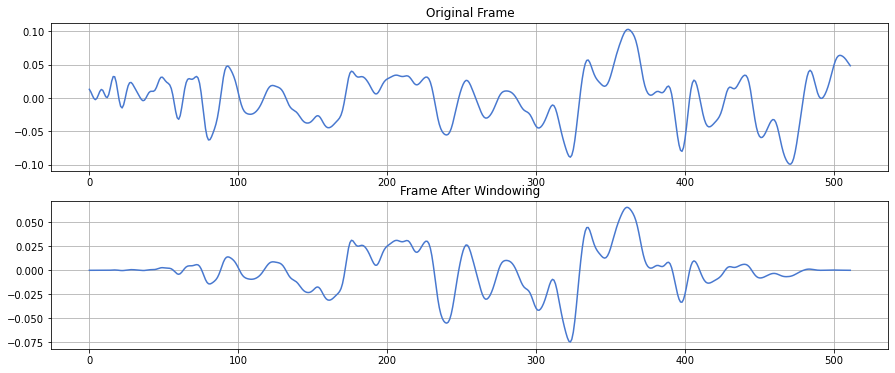

In [19]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [20]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [21]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(300, 257)


In [22]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 40

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [23]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [24]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [25]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([  0,   0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  12,  14,
        16,  18,  20,  23,  26,  29,  32,  36,  40,  44,  49,  54,  59,
        65,  72,  79,  87,  95, 105, 115, 126, 137, 150, 164, 180, 196,
       215, 234, 256])

In [26]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

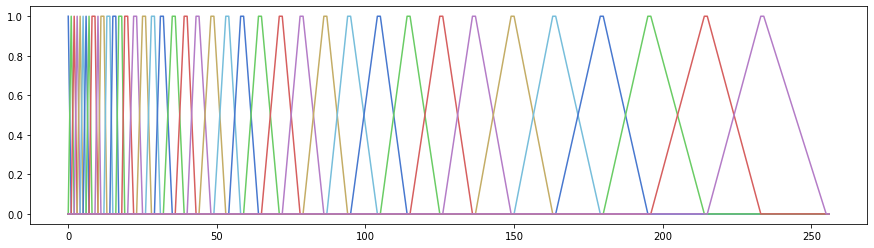

In [27]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [28]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

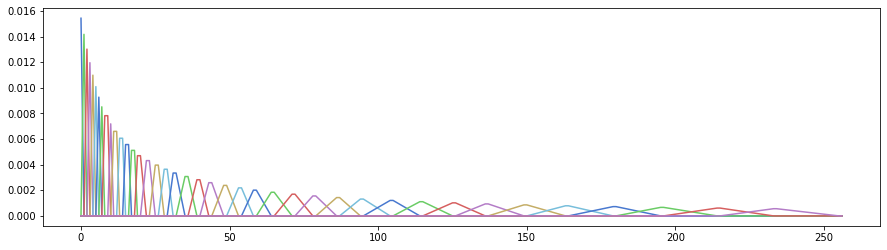

In [29]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [30]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(40, 300)

In [31]:
audio_log_delta = librosa.feature.delta(audio_log)

In [32]:
audio_log_delta_delta = librosa.feature.delta(audio_log_delta)

In [36]:
np.concatenate(audio_log,audio_log_delta, audio_log_delta_delta, axis = 0)

TypeError: concatenate() got multiple values for argument 'axis'

In [39]:
np.array([audio_log, audio_log_delta, audio_log_delta_delta]).shape

(3, 40, 300)

In [40]:
def generate_mels(audio, sr):
    audio = normalize_audio(y)
    
    hop_size = 10 #ms
    FFT_size = 512

    audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)
    window = get_window("hann", FFT_size, fftbins=True)
    
    audio_win = audio_framed * window
    
    audio_winT = np.transpose(audio_win)

    audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

    audio_fft = np.transpose(audio_fft)
    
    audio_power = np.square(np.abs(audio_fft))
    
    freq_min = 0
    freq_high = sr / 2
    mel_filter_num = 40
    
    filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
    filters = get_filters(filter_points, FFT_size)
    
    # taken from the librosa library
    enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
    filters *= enorm[:, np.newaxis]
    
    audio_filtered = np.dot(filters, np.transpose(audio_power))
    audio_log = 10.0 * np.log10(audio_filtered)
    audio_log_delta = librosa.feature.delta(audio_log)
    audio_log_delta_delta = librosa.feature.delta(audio_log_delta)
    
    return np.array([audio_log, audio_log_delta, audio_log_delta_delta])
    

In [41]:
generate_mels(audio, sr)

MEL min: 0.0
MEL max: 3923.337321740179


array([[[-5.84749945e+00, -1.82704666e+01, -1.82560355e+01, ...,
         -2.19203164e+01, -6.37186741e+01, -2.55495155e+01],
        [-8.97806490e+00, -9.05692019e+00, -1.60457191e+01, ...,
         -2.42751995e+01, -3.29127515e+01, -2.69701200e+01],
        [-1.44731282e+01, -5.24046183e+00, -1.42487420e+01, ...,
         -2.88153536e+01, -3.21601865e+01, -2.82117421e+01],
        ...,
        [-8.01221314e+01, -1.55877755e+02, -1.54423781e+02, ...,
         -1.43085545e+02, -1.50393444e+02, -1.49122771e+02],
        [-8.08047297e+01, -1.58640609e+02, -1.57950484e+02, ...,
         -1.46316700e+02, -1.51780509e+02, -1.49383418e+02],
        [-8.12963385e+01, -1.59602679e+02, -1.62382253e+02, ...,
         -1.49827069e+02, -1.52579708e+02, -1.49889979e+02]],

       [[-3.52325837e+00, -3.52325837e+00, -3.52325837e+00, ...,
          7.96960999e-01,  7.96960999e-01,  7.96960999e-01],
        [-1.42095021e+00, -1.42095021e+00, -1.42095021e+00, ...,
          1.57700761e-01,  1.57700761e

136    fru
Name: emotion, dtype: object


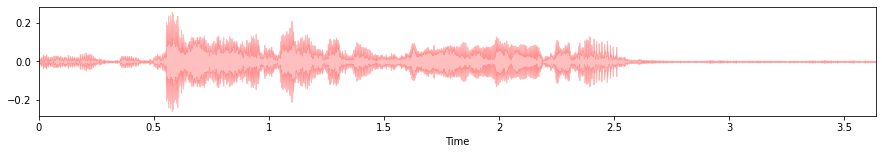

In [59]:
import math
import random
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import pandas as pd

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

data_dir = 'pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

# Pick a Random File
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

filter = labels_df['wav_file']== random_file_name
  
# filtering data
print(labels_df[filter].emotion)

import IPython.display as ipd
yt, index = librosa.effects.trim(y)
ipd.Audio(yt, rate=sr)

In [60]:
generate_mels(y, sr)

MEL min: 0.0
MEL max: 3923.337321740179


array([[[-1.16782313e+01, -7.73693337e+00, -1.09366312e+01, ...,
         -1.33416166e+01, -1.32968629e+01, -2.95608359e+01],
        [-1.00026564e+01, -6.24432531e+00, -6.94190434e+00, ...,
         -1.44009602e+01, -1.44201820e+01, -1.83886195e+01],
        [-5.44172255e+00, -7.37487610e+00, -6.34890923e+00, ...,
         -3.32558909e+01, -2.19054612e+01, -1.91105312e+01],
        ...,
        [-1.50092627e+02, -9.88742527e+01, -1.46883544e+02, ...,
         -1.64507632e+02, -1.65462826e+02, -1.64492818e+02],
        [-1.53184234e+02, -9.94477160e+01, -1.49856025e+02, ...,
         -1.67302390e+02, -1.70476409e+02, -1.67243322e+02],
        [-1.56832319e+02, -9.98704339e+01, -1.54090515e+02, ...,
         -1.68085896e+02, -1.69520359e+02, -1.70143161e+02]],

       [[-2.00767056e+00, -2.00767056e+00, -2.00767056e+00, ...,
         -1.34843626e+00, -1.34843626e+00, -1.34843626e+00],
        [-2.61820854e-01, -2.61820854e-01, -2.61820854e-01, ...,
          2.55009136e-01,  2.55009136e